In [1]:
%load_ext autoreload
%autoreload 2

### data loading and preparation

In [2]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
seed = 0

In [3]:
proj_name = "dkd_Wilson"
file_name = "dkd_Wilson"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [4]:
adata = sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [15]:
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad", compression='gzip')

### Create jobs

In [5]:
concord_args = {
        'save_dir': '../'+str(save_dir) # Directory to save the model and results
    }

In [18]:
adata.obs.columns

Index(['donor_id', 'self_reported_ethnicity_ontology_term_id',
       'organism_ontology_term_id', 'sample_uuid',
       'sample_preservation_method', 'tissue_ontology_term_id',
       'development_stage_ontology_term_id', 'suspension_uuid',
       'suspension_type', 'library_uuid', 'assay_ontology_term_id',
       'mapped_reference_annotation', 'is_primary_data',
       'cell_type_ontology_term_id', 'author_cell_type',
       'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id',
       'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl',
       'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT',
       'seurat_clusters', 'tissue_type', 'cell_type', 'assay', 'disease',
       'organism', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'observation_joinid'],
      dtype='object')

In [6]:
import subprocess, json
output_dir = "../jobs"
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)      
#py_methods = ["concord_hcl", "concord_knn"]
py_methods = ['liger']
output_dir = '../jobs'
device = 'auto'
conda_env = 'concord'
batch_key = 'donor_id'
state_key = 'None'
latent_dim = '50'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--runtime", "02:00:00",
    "--concord_kwargs", json.dumps(concord_args),
    "--verbose"
])


✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_liger.py
✅ Generated: benchmark_dkd_Wilson/benchmark_dkd_Wilson_liger.sh



CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'dkd_Wilson', '--adata_filename', 'dkd_Wilson_preprocessed.h5ad', '--methods', 'liger', '--batch_key', 'donor_id', '--state_key', 'None', '--latent_dim', '50', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'concord', '--runtime', '02:00:00', '--concord_kwargs', '{"save_dir": "../../save/dkd_Wilson"}', '--verbose'], returncode=0)

In [8]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = """#!/bin/bash
set -euo pipefail
cd "$(dirname "$0")"           # work inside this folder
shopt -s nullglob              # empty globs expand to nothing

for job in *.py; do            # <<──  changed from jobs/*.py to *.py
  echo ">>> $job   $(date)" | tee -a all_runs.log
  if python "$job" >> all_runs.log 2>&1; then
      echo ">>> finished OK"   | tee -a all_runs.log
  else
      echo ">>> FAILED"        | tee -a all_runs.log
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_dkd_Wilson/submit_sequential_dkd_Wilson.sh” to queue jobs sequentially.


### Collect results

In [20]:
# Delete existing latents in adata.obsm
for key in list(adata.obsm.keys()):
    del adata.obsm[key]

In [9]:
methods = ["liger", "concord_hcl", "concord_knn"]
from benchmark_utils import add_embeddings
# ---------------------------- Add Embeddings ----------------------------
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

✅ obsm['liger'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded


In [13]:
adata.obsm['liger']

array([[4.74670560e-04, 0.00000000e+00, 3.70672908e-05, ...,
        1.80532256e-05, 1.09906473e-04, 2.11341495e-05],
       [2.52830332e-04, 1.39468737e-04, 4.93960117e-05, ...,
        1.24121216e-03, 2.08202901e-03, 1.64771793e-06],
       [1.08562793e-05, 2.27591924e-06, 1.49345188e-03, ...,
        3.39950124e-05, 8.14175441e-04, 4.62103671e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.44007892e-04, 1.87515567e-04, ...,
        0.00000000e+00, 0.00000000e+00, 3.33357492e-04],
       [7.81120063e-03, 0.00000000e+00, 5.81219712e-04, ...,
        2.01398921e-04, 0.00000000e+00, 0.00000000e+00]],
      shape=(39176, 50))

In [25]:
for method in methods:
    if f"{method}_UMAP" in adata.obsm:
        print(f"[⚠️ Warning] obsm['{method}_UMAP'] already exists, skipping UMAP computation")
    else:
        print(f"Computing 2D UMAP for {method}...")
        ccd.ul.run_umap(adata, source_key=f"{method}", result_key=f"{method}_UMAP", n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
        print(f"✅ obsm['{method}_UMAP'] computed")

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
print(f"✅ Embeddings saved to {save_dir / f'obsm_{file_suffix}.h5'}")
final_path = data_dir / f"{file_name}_final.h5ad"
adata.write_h5ad(final_path)
print(f"✅ Final AnnData saved to: {final_path}")

Computing 2D UMAP for concord_hcl...
Concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
✅ obsm['concord_hcl_UMAP'] computed
Computing 2D UMAP for concord_knn...
Concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
✅ obsm['concord_knn_UMAP'] computed
✅ Embeddings saved to ../save/dkd_Wilson/obsm_Jul01-2011.h5
✅ Final AnnData saved to: ../data/dkd_Wilson/dkd_Wilson_final.h5ad


✅ Benchmark summary saved to: ../save/dkd_Wilson/benchmark_summary_Jul02-0150.tsv


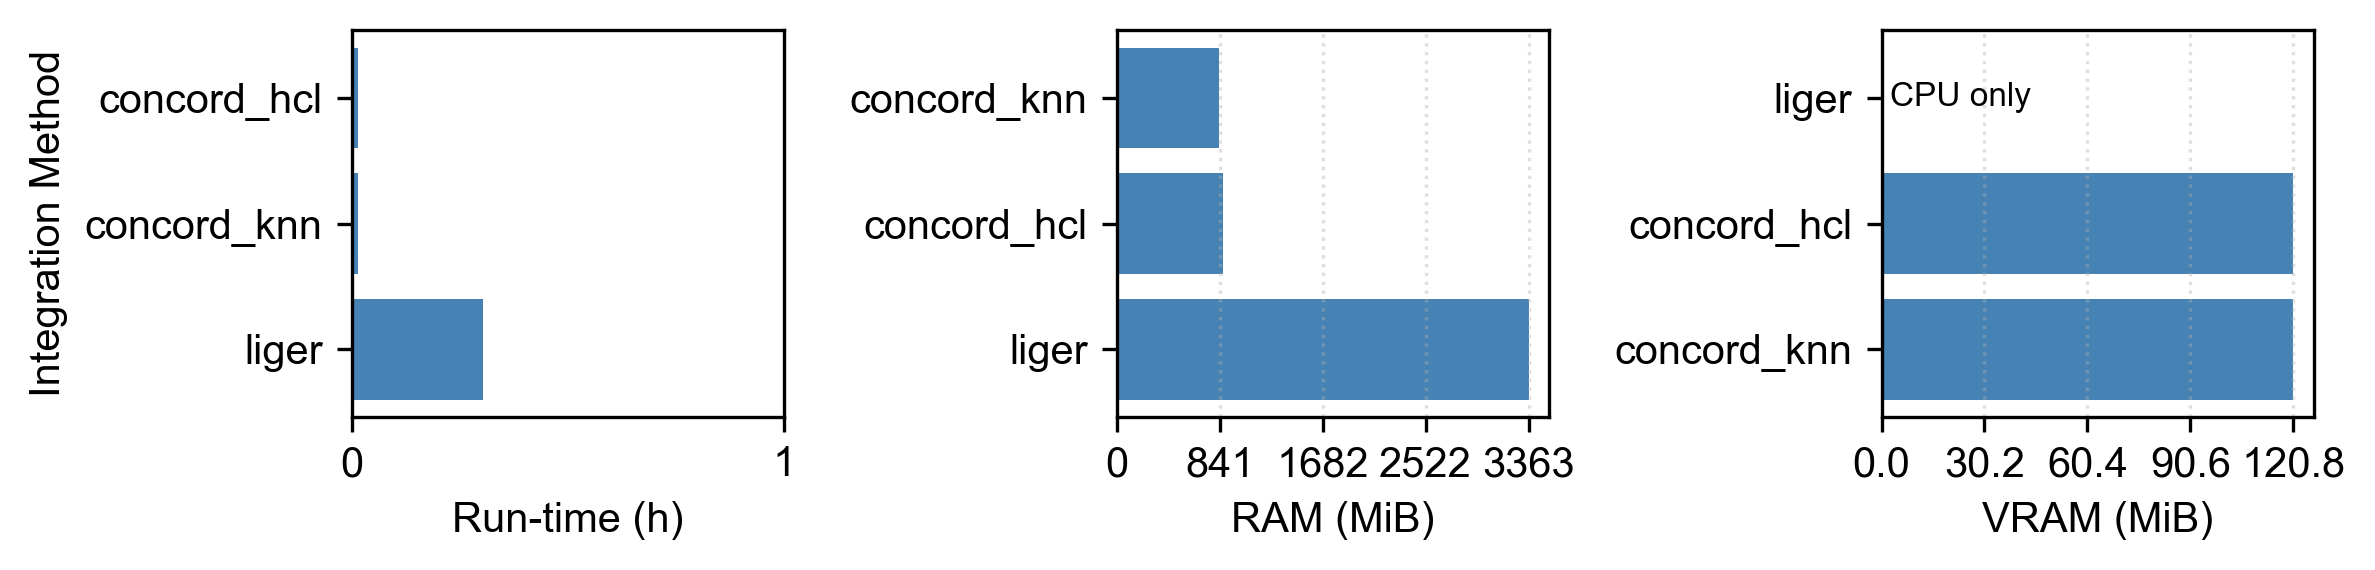

In [12]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(file_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


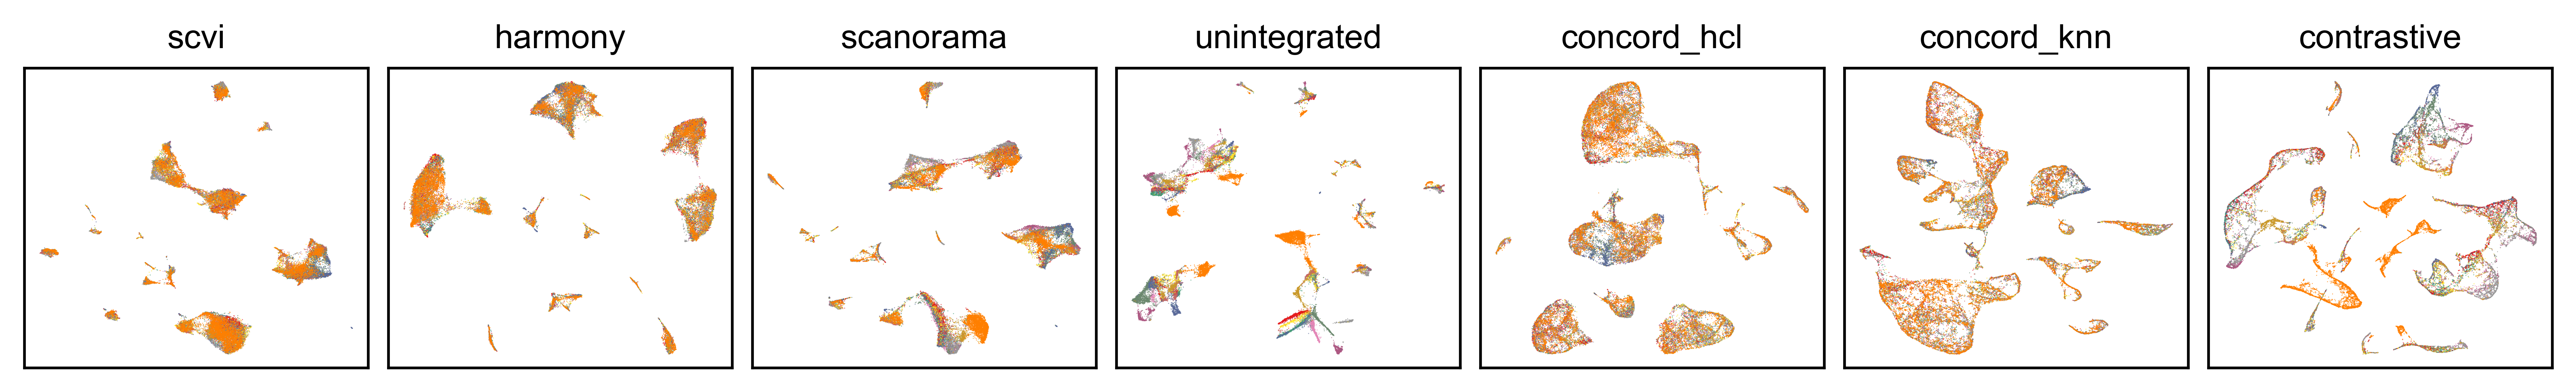

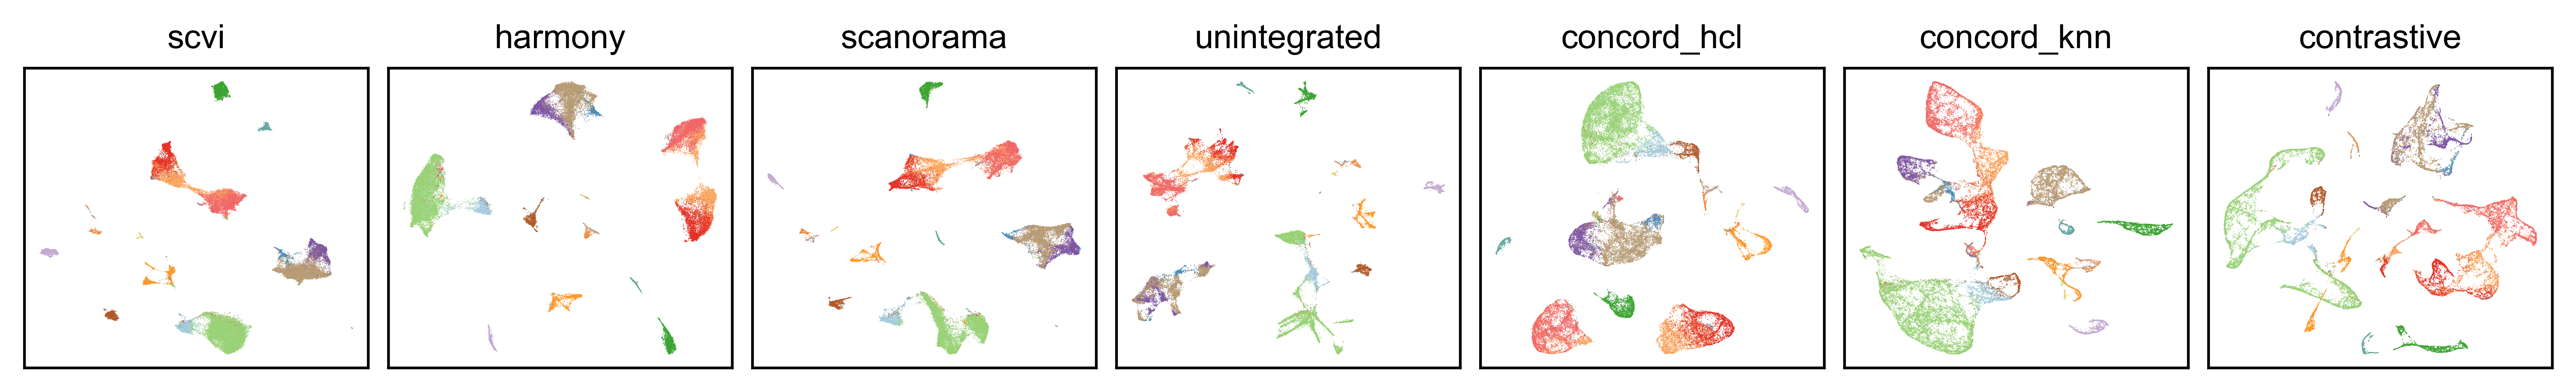

In [6]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = py_methods
show_cols = ['donor_id', 'author_cell_type']
basis_types = ['UMAP']

font_size=10
point_size=.3
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'donor_id': 'Set1',
       "author_cell_type": 'Paired',}

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


Detected task: classification
Detected task: classification
[KNN] detected task: classification
[KNN] detected task: classification


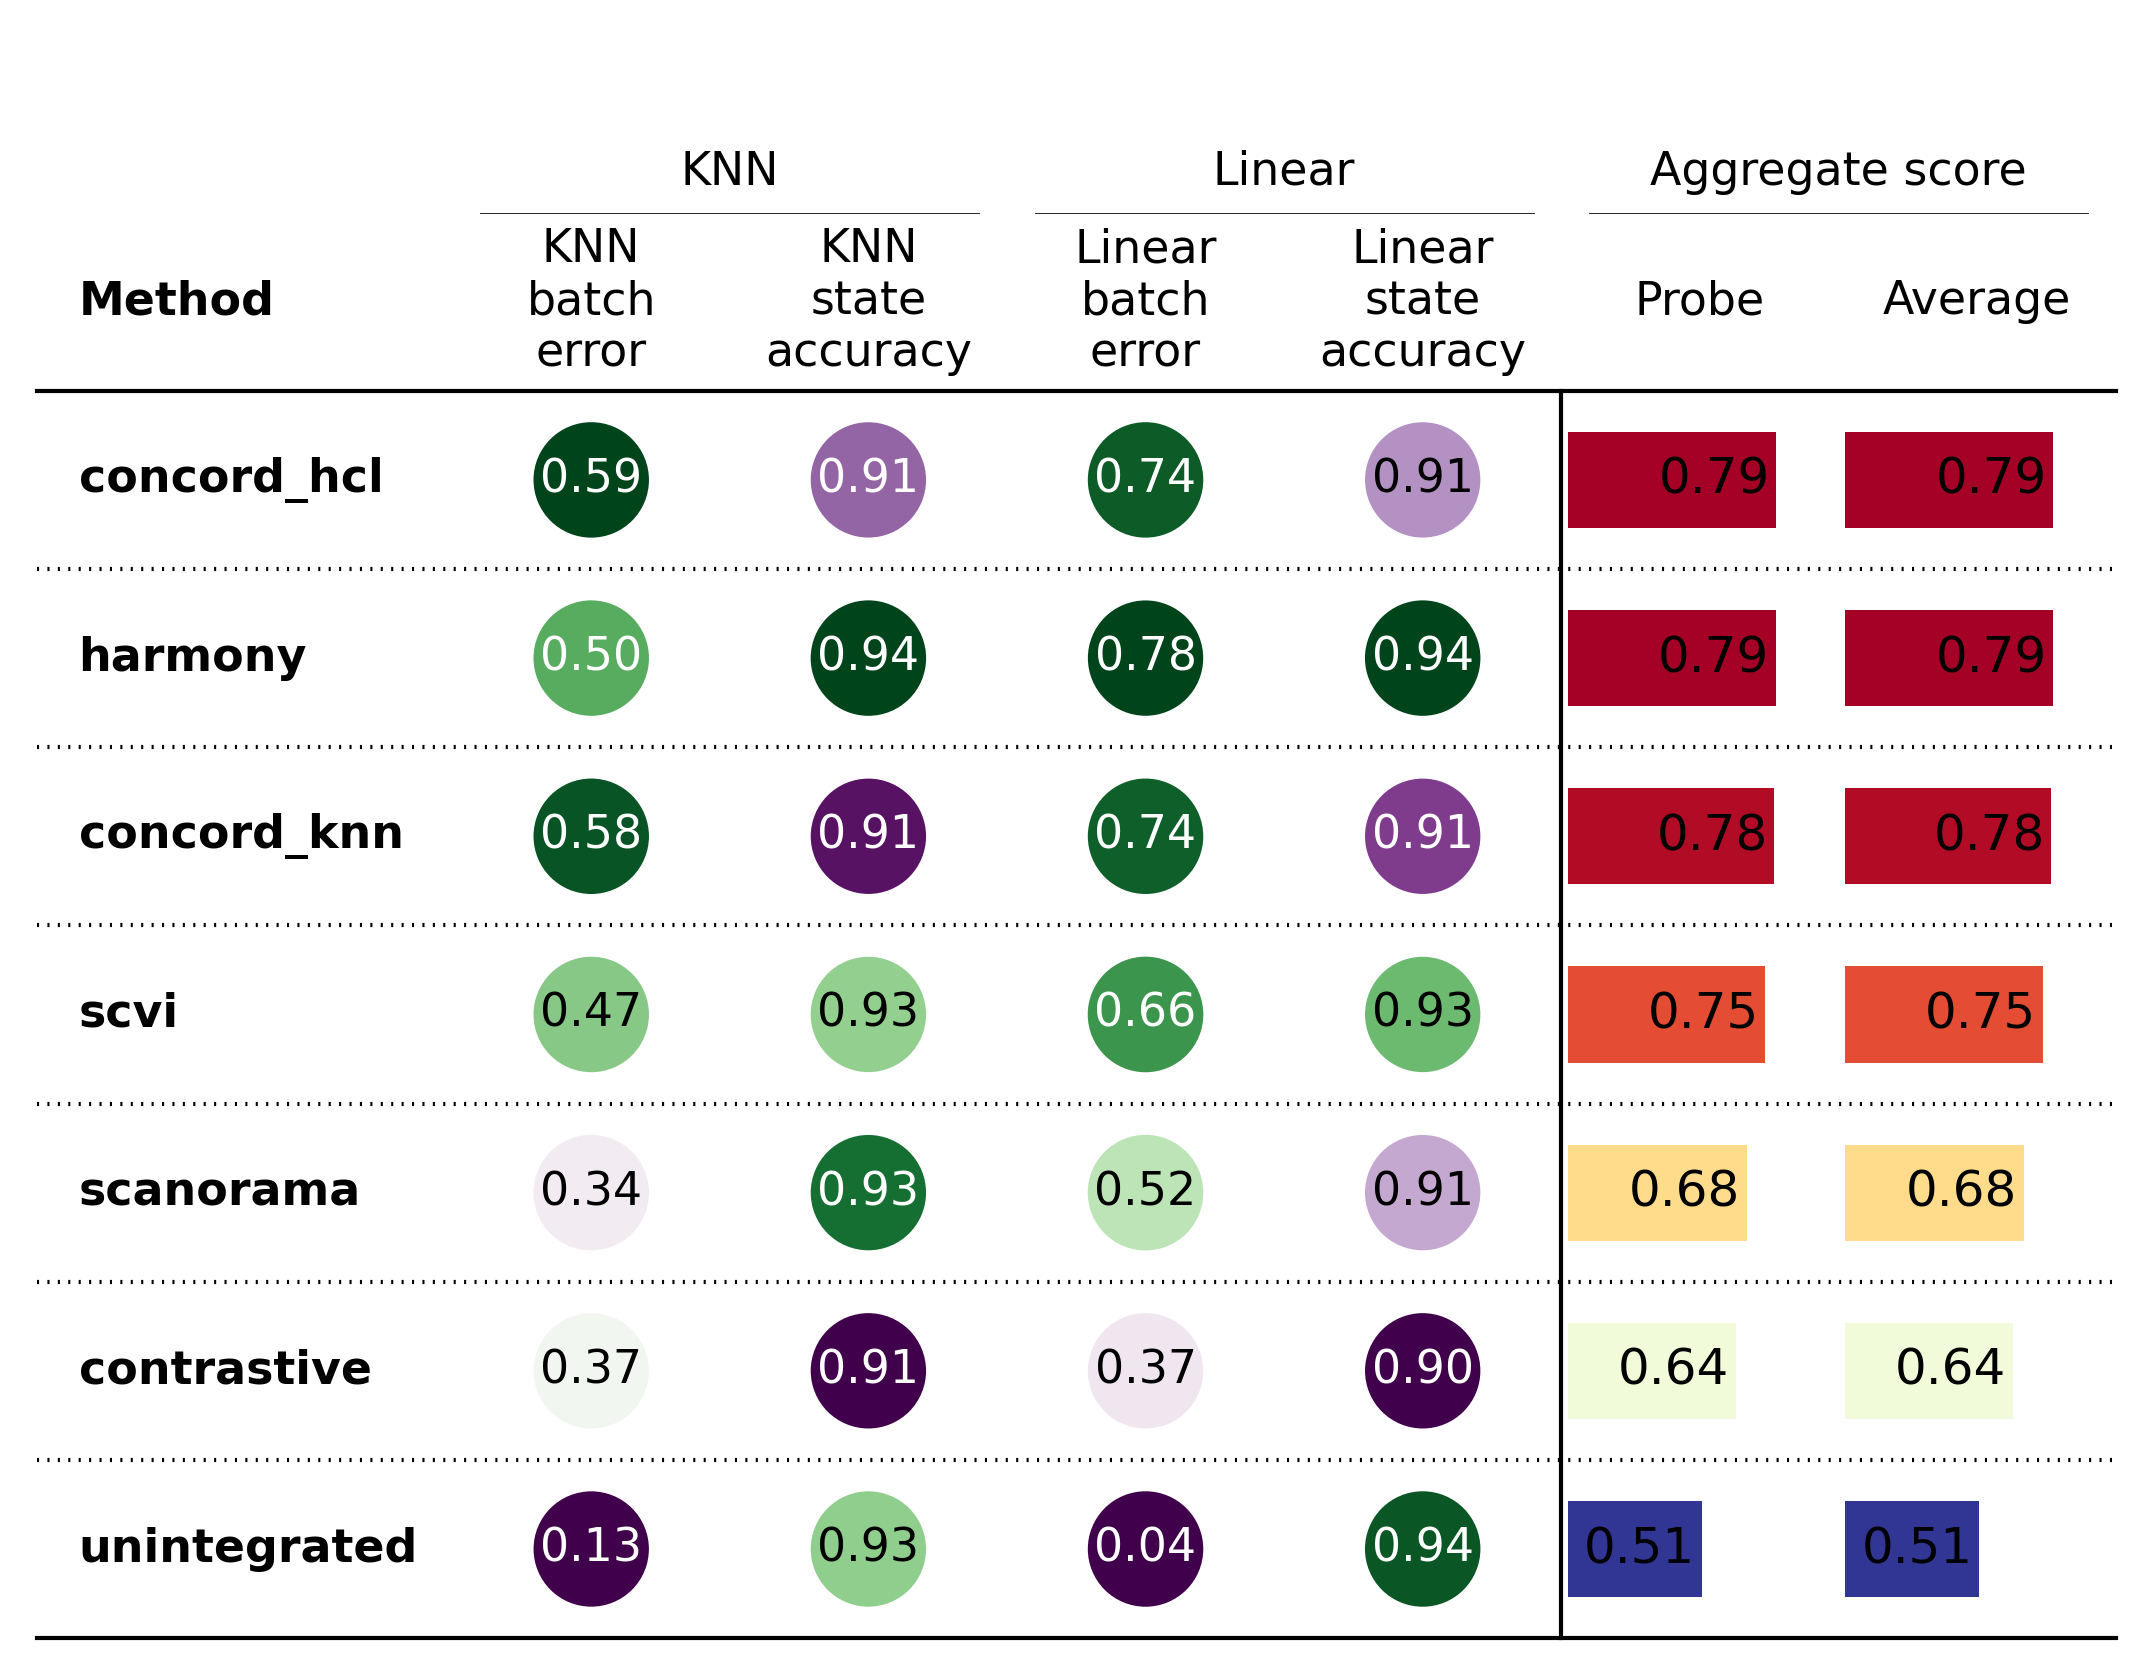

✅ Benchmark results saved to: ../save/dkd_Wilson/benchmark_author_cell_type_Jun29-2215.pkl


In [12]:
state_key = 'author_cell_type'
batch_key = 'donor_id'
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=py_methods,
    state_key=state_key,
    batch_key=batch_key,
    save_dir=save_dir / "benchmarks_celltype",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("probe"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
)
combined_celltype = out["combined"]

# Save the benchmark results
import pickle
with open(save_dir / f"benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
    pickle.dump(out, f)

print(f"✅ Benchmark results saved to: {save_dir / f'benchmark_{state_key}_{file_suffix}.pkl'}")

In [8]:
out['probe']

KNN                          Linear                  \
             batch\naccuracy state\naccuracy batch\naccuracy state\naccuracy   
Method                                                                         
unintegrated        0.872384        0.927642        0.963114        0.940140   
contrastive         0.631955        0.905181        0.629228        0.901851   
scanorama           0.655309        0.933512        0.479004        0.913976   
scvi                0.528841        0.927514        0.338354        0.932610   
harmony             0.500255        0.936064        0.223740        0.941544   
concord_knn         0.423430        0.906585        0.263816        0.906956   
concord_hcl         0.407989        0.910924        0.258583        0.912317   

                 Probe  
                 Score  
Method                  
unintegrated  0.925820  
contrastive   0.767054  
scanorama     0.745450  
scvi          0.681830  
harmony       0.650401  
concord_knn   0.625197  
concord_hcl   0.622453